In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score


df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
df_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")


<Axes: >

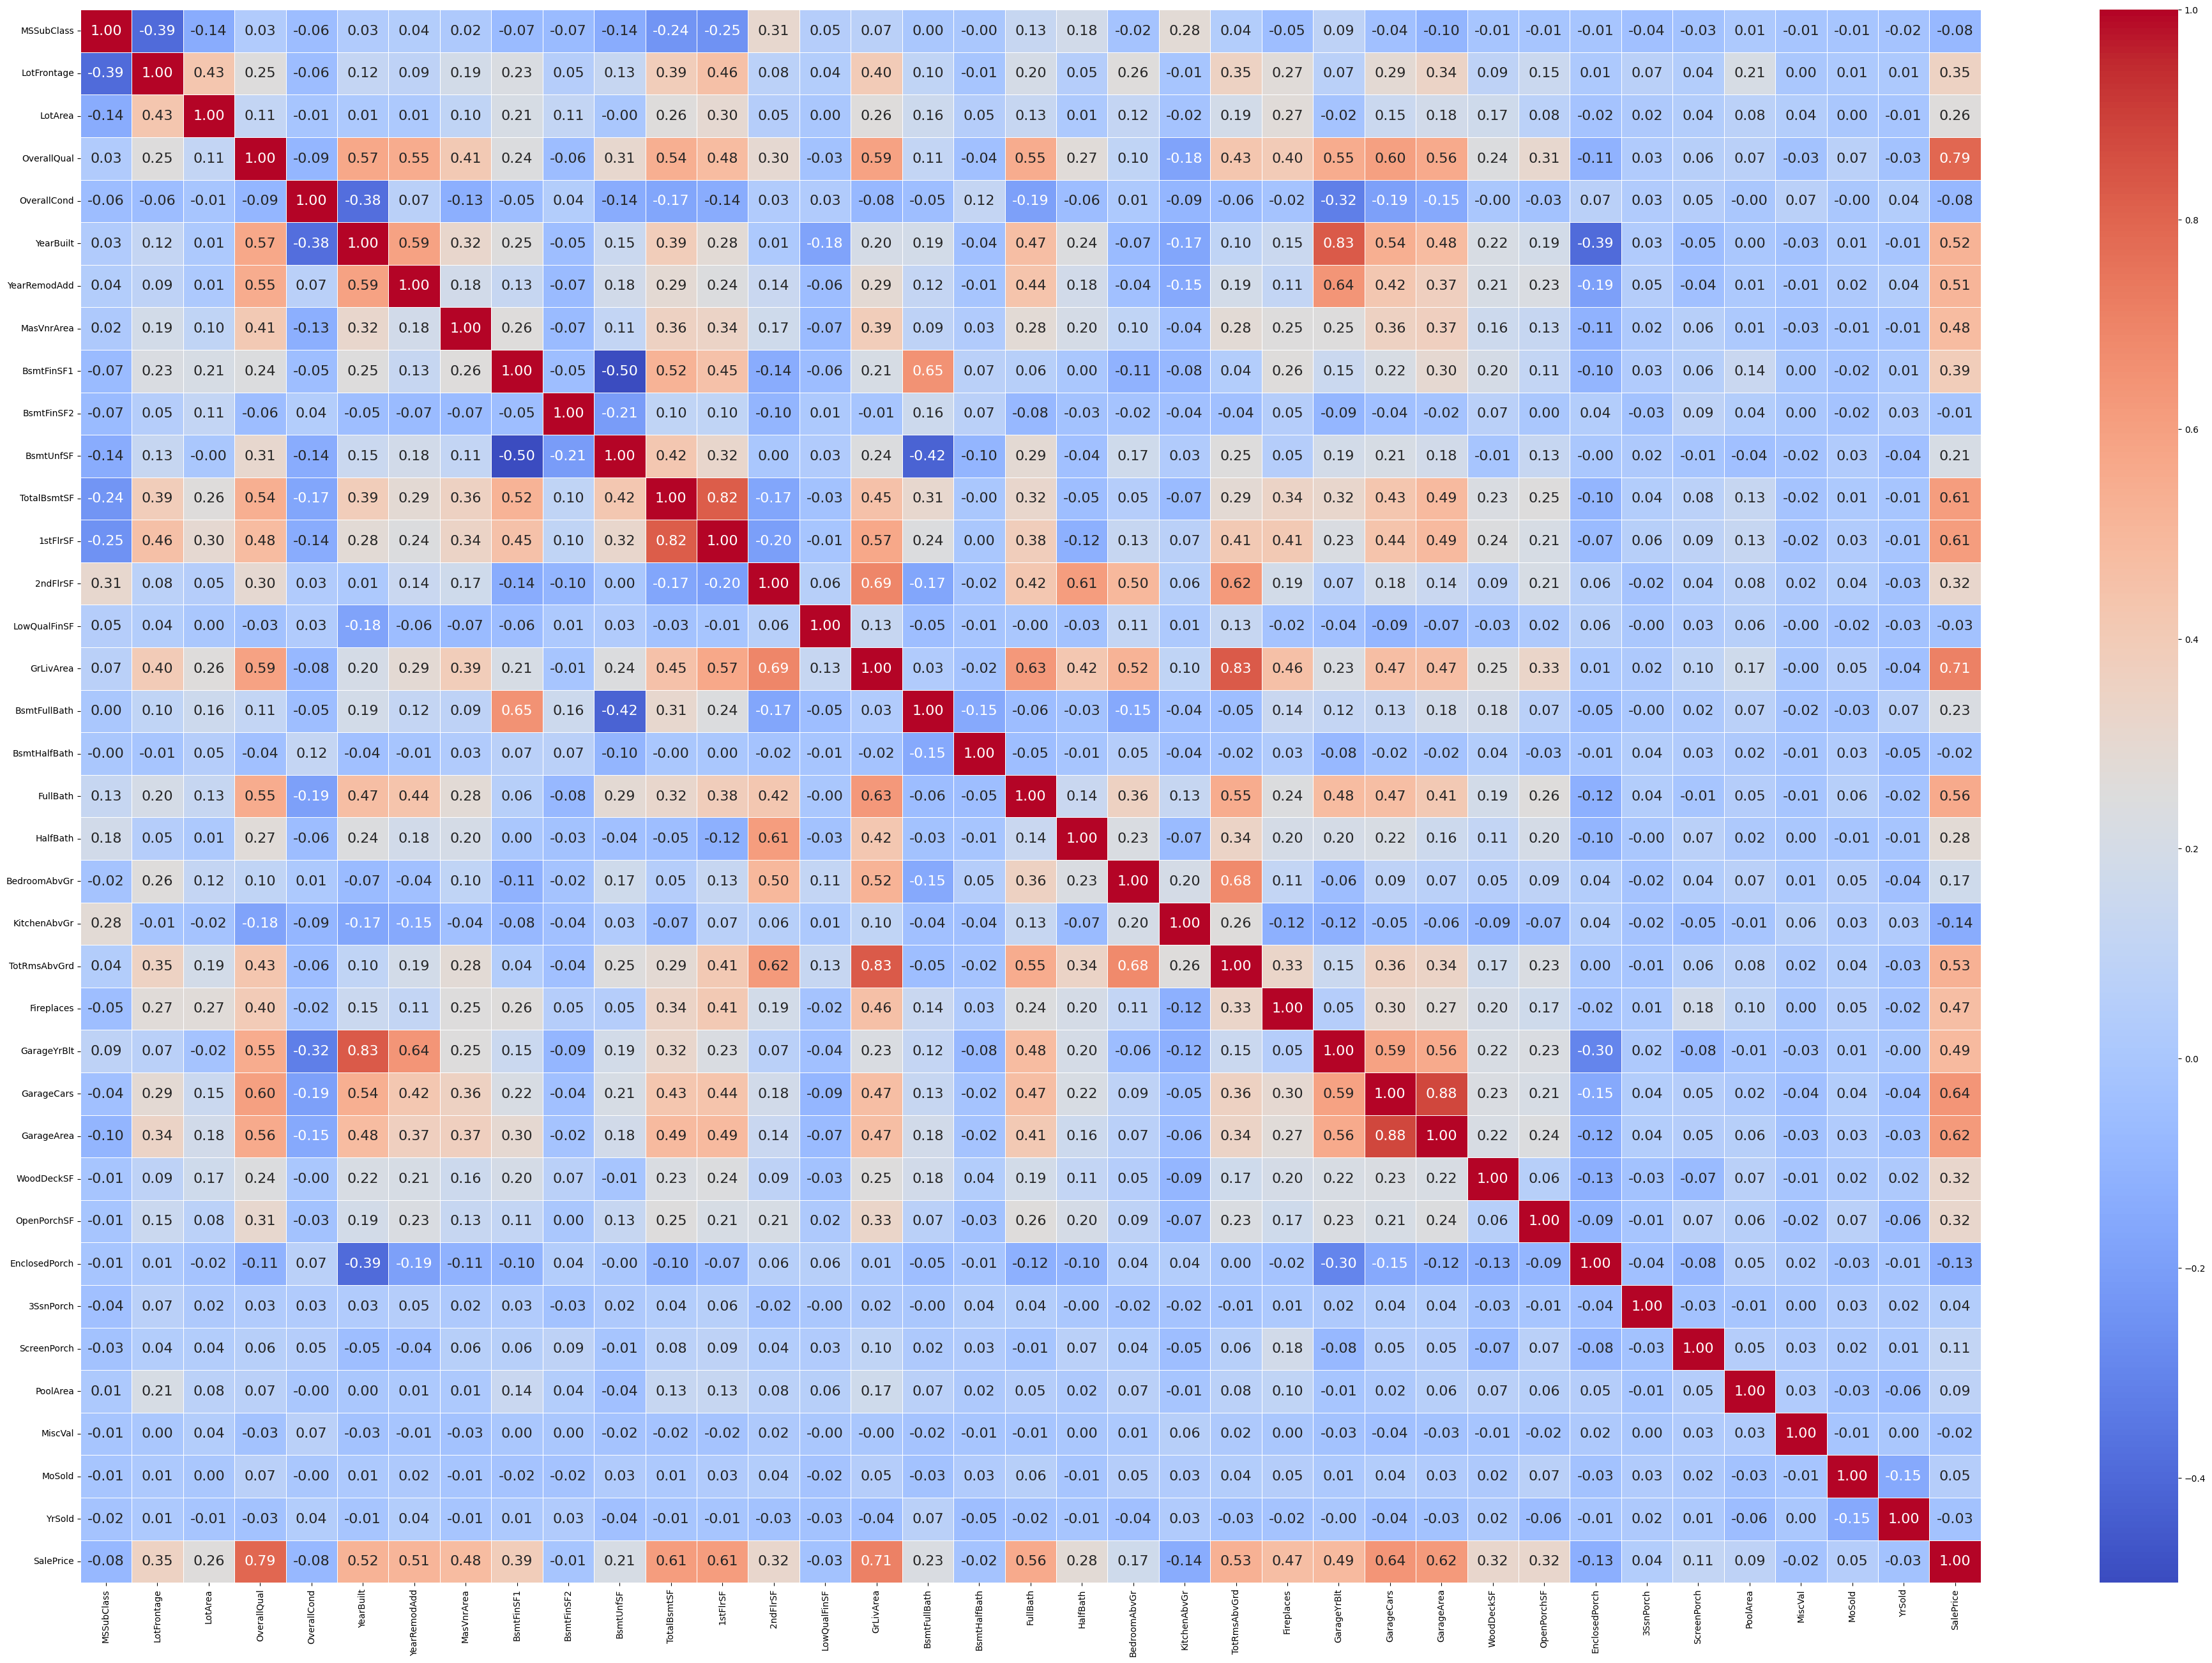

In [2]:
#check for multicollinearity
num_df = df.select_dtypes(exclude=['object'])
num_df = num_df.drop(["Id"], axis=1)
df_cor = num_df.corr().round(2)
plt.figure(figsize=(48,32))
sns.heatmap(df_cor, annot=True, cmap='coolwarm', fmt="0.2f", linewidths=0.5, annot_kws={"size": 16})

#note garage area and garage cars
#best predictors likely to be OverallQual and GrLivArea

In [3]:
#null values
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0])

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [4]:
# 1 Select only numerical columns
numeric_feats = df.dtypes[df.dtypes != "object"].index

# 2 Calculate skewness and drop missing values
skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

# 3 Create a readable DataFrame
skewness = pd.DataFrame({'Skew' :skewed_feats})

# 4 Filter for high skewness
high_skew = skewness[abs(skewness) > 0.75].dropna()
print(high_skew)

                    Skew
MiscVal        24.451640
PoolArea       14.813135
LotArea        12.195142
3SsnPorch      10.293752
LowQualFinSF    9.002080
KitchenAbvGr    4.483784
BsmtFinSF2      4.250888
ScreenPorch     4.117977
BsmtHalfBath    4.099186
EnclosedPorch   3.086696
MasVnrArea      2.666326
OpenPorchSF     2.361912
LotFrontage     2.160866
SalePrice       1.880941
BsmtFinSF1      1.683771
WoodDeckSF      1.539792
TotalBsmtSF     1.522688
MSSubClass      1.406210
1stFlrSF        1.375342
GrLivArea       1.365156
BsmtUnfSF       0.919323
2ndFlrSF        0.812194


In [12]:
def scan_outliers(data):
    # Select only numeric columns
    numeric_df = data.select_dtypes(include=['number'])
    outlier_report = []

    for col in numeric_df.columns:
        Q1 = numeric_df[col].quantile(0.25)
        Q3 = numeric_df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers
        outliers = numeric_df[(numeric_df[col] < lower_bound) | (numeric_df[col] > upper_bound)]
        
        if len(outliers) > 0:
            outlier_report.append({
                'Variable': col,
                'Outlier Count': len(outliers),
                'Percentage': f"{(len(outliers) / len(data)) * 100:.2f}%",
                'Max Value': numeric_df[col].max(),
                'Min Value': numeric_df[col].min()
            })

    # Convert to DataFrame and sort by count
    return pd.DataFrame(outlier_report).sort_values(by='Outlier Count', ascending=False)

# Run the scan
report = scan_outliers(df)
print(report)

         Variable  Outlier Count Percentage  Max Value  Min Value
25  EnclosedPorch            208     14.25%      552.0        0.0
8      BsmtFinSF2            167     11.44%     1474.0        0.0
4     OverallCond            125      8.56%        9.0        1.0
27    ScreenPorch            116      7.95%      480.0        0.0
0      MSSubClass            103      7.05%      190.0       20.0
6      MasVnrArea             96      6.58%     1600.0        0.0
1     LotFrontage             88      6.03%      313.0       21.0
16   BsmtHalfBath             82      5.62%        2.0        0.0
24    OpenPorchSF             77      5.27%      547.0        0.0
2         LotArea             69      4.73%   215245.0     1300.0
18   KitchenAbvGr             68      4.66%        3.0        0.0
30      SalePrice             61      4.18%   755000.0    34900.0
10    TotalBsmtSF             61      4.18%     6110.0        0.0
29        MiscVal             52      3.56%    15500.0        0.0
17   Bedro

In [16]:
def full_preprocess(input_df):
    df = input_df.copy()
    
    # Drop initial columns with too many missing values
    cols_to_drop = ['Alley', 'PoolQC', 'Fence', 'Utilities', 'MasVnrArea', 'MiscFeature', 'MiscVal']
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

    # Ordinal Mapping (Fixes the 'Reg' / String-to-Float errors)
    q_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
    f_map = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
    func_map = {'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0}
    
    ord_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
    
    for col in ord_cols:
        if col in df.columns:
            df[col] = df[col].fillna('None').map(q_map)

    # Specific ordinal columns
    if 'BsmtFinType1' in df.columns: df['BsmtFinType1'] = df['BsmtFinType1'].fillna('None').map(f_map)
    if 'BsmtFinType2' in df.columns: df['BsmtFinType2'] = df['BsmtFinType2'].fillna('None').map(f_map)
    if 'BsmtExposure' in df.columns: df['BsmtExposure'] = df['BsmtExposure'].fillna('None').map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0})
    if 'GarageFinish' in df.columns: df['GarageFinish'] = df['GarageFinish'].fillna('None').map({'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0})
    if 'LotShape' in df.columns:    df['LotShape'] = df['LotShape'].map({'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0})
    if 'LandSlope' in df.columns:   df['LandSlope'] = df['LandSlope'].map({'Gtl': 2, 'Mod': 1, 'Sev': 0})
    if 'PavedDrive' in df.columns:  df['PavedDrive'] = df['PavedDrive'].map({'Y': 2, 'P': 1, 'N': 0})
    if 'CentralAir' in df.columns:  df['CentralAir'] = df['CentralAir'].map({'Y': 1, 'N': 0}) 
    if 'Functional' in df.columns:  df['Functional'] = df['Functional'].fillna('Typ').map(func_map)

    # Derived Features
    df['PropertyAge'] = df['YrSold'] - df['YearBuilt']
    df['TotSF'] = df['TotalBsmtSF'].fillna(0) + df['1stFlrSF'].fillna(0) + df['2ndFlrSF'].fillna(0)
    df['TotBath'] = df['FullBath'].fillna(0) + 0.5*df['HalfBath'].fillna(0) + df['BsmtFullBath'].fillna(0) + 0.5*df['BsmtHalfBath'].fillna(0)
    df['TotPorchSF'] = df['OpenPorchSF'].fillna(0) + df['EnclosedPorch'].fillna(0) + df['3SsnPorch'].fillna(0) + df['ScreenPorch'].fillna(0) + df['WoodDeckSF'].fillna(0)
    
    # Log transform LotArea (consistent with your original code)
    df['Log_LotArea'] = np.log1p(df['LotArea'])

    # Handle remaining nominals (Categoricals) with One-Hot Encoding
    obj_cols = df.select_dtypes(include=['object']).columns
    df = pd.get_dummies(df, columns=obj_cols)

    # Drop original columns replaced by derived/log features
    cols_to_drop_final = ['YrSold','PoolArea','YearBuilt','LotFrontage', 'TotalBsmtSF', 
                          '1stFlrSF', '2ndFlrSF', 'FullBath', 'HalfBath', 
                          'BsmtFullBath','BsmtHalfBath','YearRemodAdd','GarageArea',
                          'OpenPorchSF','3SsnPorch','ScreenPorch','WoodDeckSF', 'LotArea']
    df = df.drop(columns=[c for c in cols_to_drop_final if c in df.columns], errors='ignore')

    # Final Numeric Impute (Fill NaNs with median for StandardScaler)
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    
    return df

In [17]:


# --- 3 train/test prep
# Remove outliers from training data only
df_train_clean = df[df['GrLivArea'] < 4000].copy()
df_train_clean = df_train_clean[df_train_clean['LotArea'] < 100000].copy()

# Apply preprocessing
train_processed = full_preprocess(df_train_clean)
test_processed = full_preprocess(df_test)

# Define Target (y) using Log Transform
y_train = np.log1p(df_train_clean['SalePrice'])

# Align Features (X) (this one took my r^2 from .90 to .94)
X_train = train_processed.drop(columns=['Id', 'SalePrice', 'Log_SalePrice'], errors='ignore')
X_test = test_processed.reindex(columns=X_train.columns, fill_value=0)

# 4 scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5 model training (Lasso)
lasso = LassoCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1], cv=5, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

# 6 performance metrics
train_preds_log = lasso.predict(X_train_scaled)

# Metrics in Log Space
r2_train = r2_score(y_train, train_preds_log)
rmse_log = np.sqrt(mean_squared_error(y_train, train_preds_log))

# Metrics in Dollar Space
train_preds_dollars = np.expm1(train_preds_log)
y_train_dollars = np.expm1(y_train)
rmse_dollars = np.sqrt(mean_squared_error(y_train_dollars, train_preds_dollars))

print(f"--- Training Results ---")
print(f"R-squared:      {r2_train:.4f}")
print(f"RMSE (Log):     {rmse_log:.4f}")
print(f"RMSE (Dollars): ${rmse_dollars:,.2f}")



--- Training Results ---
R-squared:      0.9403
RMSE (Log):     0.0966
RMSE (Dollars): $17,610.05


In [18]:
# 7 final
test_preds_log = lasso.predict(X_test_scaled)
test_preds_final = np.expm1(test_preds_log)

submission = pd.DataFrame({
    "Id": df_test["Id"],
    "SalePrice": test_preds_final
})

submission.to_csv("submission.csv", index=False)
print("\nSubmission.csv has been created!")


Submission.csv has been created!


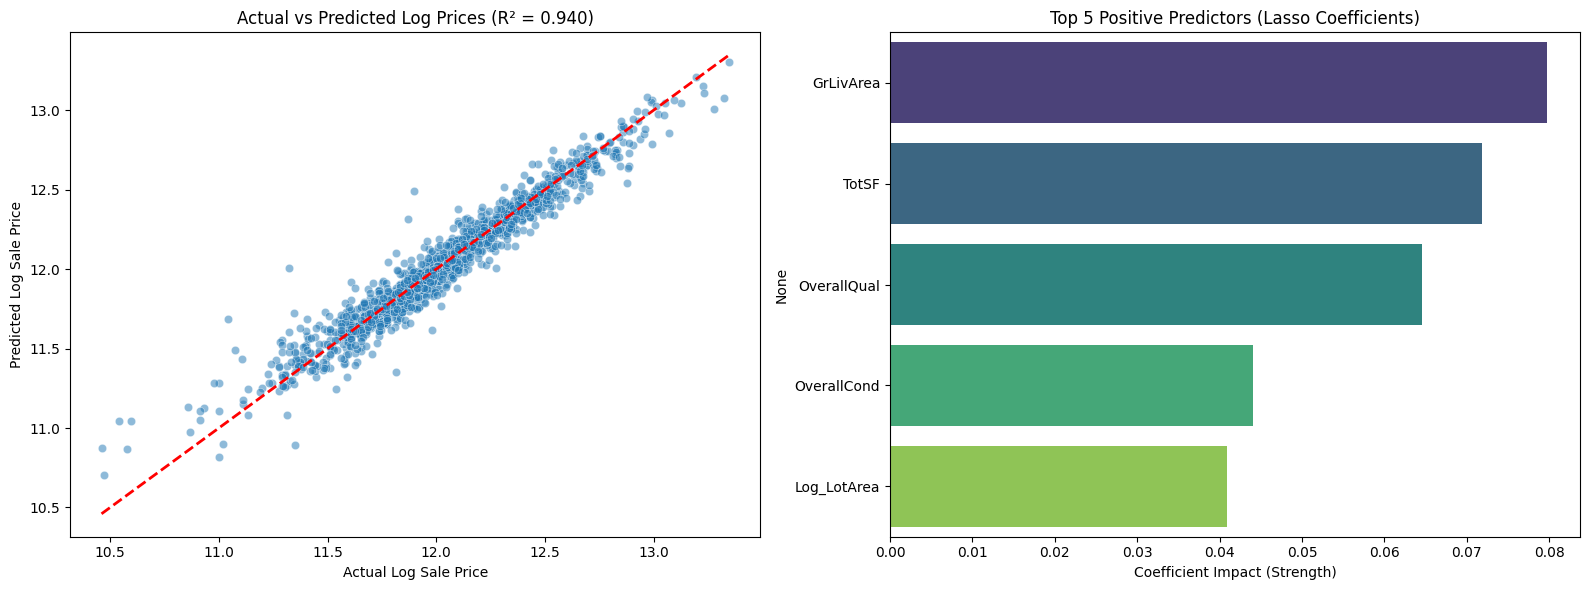

--- Top 5 Features Driving Price Increase ---
GrLivArea      0.079763
TotSF          0.071865
OverallQual    0.064589
OverallCond    0.044013
Log_LotArea    0.040914
dtype: float64


In [20]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Actual vs Predicted
# We use training data because we have the ground truth (y_train)
sns.scatterplot(x=y_train, y=train_preds_log, ax=ax1, alpha=0.5)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--r', lw=2)
ax1.set_title(f'Actual vs Predicted Log Prices (R² = {r2_train:.3f})')
ax1.set_xlabel('Actual Log Sale Price')
ax1.set_ylabel('Predicted Log Sale Price')

# Plot 2 Top 5 Predictors
# Get coefficients and map them to column names
coef_df = pd.Series(lasso.coef_, index=X_train.columns)
# Sort by absolute value to find the strongest impact
top_5 = coef_df.sort_values(ascending=False).head(5)

sns.barplot(x=top_5.values, y=top_5.index, ax=ax2, hue=top_5.index, palette='viridis', legend=False)
ax2.set_title('Top 5 Positive Predictors (Lasso Coefficients)')
ax2.set_xlabel('Coefficient Impact (Strength)')

plt.tight_layout()
plt.show()

# Print the top 5 for quick reading
print("--- Top 5 Features Driving Price Increase ---")
print(top_5)

R^2 .94 RMSE $17,000

In [ ]:
Best Predictors: 1. GrLivArea 2. TotSF 3. OverallQual 4. OverallCond 5.Log_LotArea